In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
warnings.filterwarnings("ignore")
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelBinarizer

In [ ]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))


In [ ]:
img_height = 224
img_width = 224

# Carga de datasets

In [ ]:
data_train = pd.read_csv('Train.csv',index_col=0)
data_test = pd.read_csv('Test.csv',index_col=0)

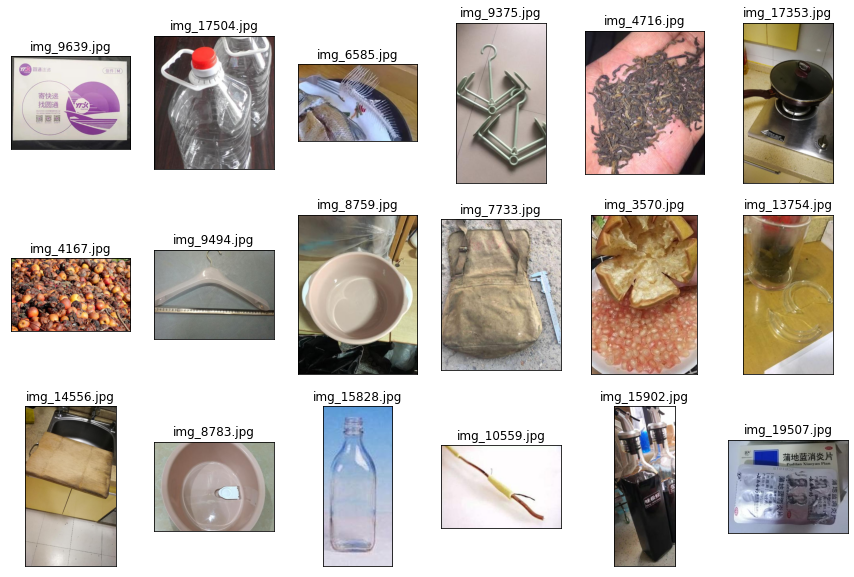

In [ ]:
imgpath  = "data/train_data/img/"
testpath = "data/test_data/img/"
fig = plt.figure(figsize=(15, 10))

for i in range(18):
    plt.subplot(3,6,i+1)
    #plt.tight_layout()
    img = mpimg.imread(imgpath+data_train['name_img'][i])
    plt.imshow(img)
    plt.title(data_train['name_img'][i])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
data_train['path'] = imgpath + data_train['name_img']
data_test['path']  = testpath + data_test['name_img']

In [ ]:
data_train.head(5)

,name_img,label_codificado,path
0,img_9639.jpg,0 32 33,data/train_data/img/img_9639.jpg
1,img_17504.jpg,0 1 27 49,data/train_data/img/img_17504.jpg
2,img_6585.jpg,0 13 14 22,data/train_data/img/img_6585.jpg
3,img_9375.jpg,0 4 31,data/train_data/img/img_9375.jpg
4,img_4716.jpg,0 13 16 19,data/train_data/img/img_4716.jpg


In [ ]:
data_test.head(5)

,name_img,path
0,img_821.jpg,data/test_data/img/img_821.jpg
1,img_1892.jpg,data/test_data/img/img_1892.jpg
2,img_17597.jpg,data/test_data/img/img_17597.jpg
3,img_16741.jpg,data/test_data/img/img_16741.jpg
4,img_1350.jpg,data/test_data/img/img_1350.jpg


In [ ]:
data_train['label_codificado'] = data_train['label_codificado'].apply(lambda x: x.split())

In [ ]:
data_train.head(5)

,name_img,label_codificado,path
0,img_9639.jpg,"[0, 32, 33]",data/train_data/img/img_9639.jpg
1,img_17504.jpg,"[0, 1, 27, 49]",data/train_data/img/img_17504.jpg
2,img_6585.jpg,"[0, 13, 14, 22]",data/train_data/img/img_6585.jpg
3,img_9375.jpg,"[0, 4, 31]",data/train_data/img/img_9375.jpg
4,img_4716.jpg,"[0, 13, 16, 19]",data/train_data/img/img_4716.jpg


In [ ]:
data_train['level']  = [x[0] for x in data_train['label_codificado']]
data_train['level1'] = [x[1] for x in data_train['label_codificado']]
data_train['level2'] = [x[2]  if len(x)>2 else -1 for x in data_train['label_codificado']]
data_train['level3'] = [x[3]  if len(x)>3 else -1 for x in data_train['label_codificado']]

In [ ]:
data_train['level'].value_counts()

0     10073
51      920
6       848
Name: level, dtype: int64

In [ ]:
 data_train['level1'].value_counts()

1     5021
13    2395
4     1082
52     920
8      632
36     505
12     316
10     309
44     257
7      223
32     181
Name: level1, dtype: int64

In [ ]:
data_train.head(5)

,name_img,label_codificado,path,level,level1,level2,level3
0,img_9639.jpg,"[0, 32, 33]",data/train_data/img/img_9639.jpg,0,32,33,-1
1,img_17504.jpg,"[0, 1, 27, 49]",data/train_data/img/img_17504.jpg,0,1,27,49
2,img_6585.jpg,"[0, 13, 14, 22]",data/train_data/img/img_6585.jpg,0,13,14,22
3,img_9375.jpg,"[0, 4, 31]",data/train_data/img/img_9375.jpg,0,4,31,-1
4,img_4716.jpg,"[0, 13, 16, 19]",data/train_data/img/img_4716.jpg,0,13,16,19


# Creando Dataframes segun nodos padres

In [ ]:
def change_label(row):
    row[-1] = '-27'
    return row

data_train.label_codificado[data_train.level3=='27'].apply(lambda x: change_label(x))
data_train['level3'] = [x[3]  if len(x)>3 else -1 for x in data_train['label_codificado']]

In [ ]:
objeto = np.array(['0', '6', '51'])
reciclable = np.unique(np.array([x[1] for x in data_train['label_codificado'] if x[0]=='0']))
no_reciclable = np.unique(np.array([x[1] for x in data_train['label_codificado'] if x[0]=='51']))              
indeterminado = np.unique(np.array([x[1] for x in data_train['label_codificado'] if x[0]=='6']))  

In [ ]:
desconocido = np.unique(np.array([x[2] for x in data_train['label_codificado'] if x[1]=='1']))
metal = np.unique(np.array([x[2] for x in data_train['label_codificado'] if x[1]=='36']))
maderas = np.unique(np.array([x[2] for x in data_train['label_codificado'] if x[1]=='8']))
plastico = np.unique(np.array([x[2] for x in data_train['label_codificado'] if x[1]=='4']))
carton = np.unique(np.array([x[2] for x in data_train['label_codificado'] if x[1]=='44']))
organicos = np.unique(np.array([x[2] for x in data_train['label_codificado'] if x[1]=='13']))
papel = np.unique(np.array([x[2] for x in data_train['label_codificado'] if x[1]=='32']))

In [ ]:
telas = np.unique(np.array([x[3] for x in data_train['label_codificado'] if len(x) > 2 if x[2]=='25']))
botellas = np.unique(np.array([x[3] for x in data_train['label_codificado'] if len(x) > 2 if x[2]=='27']))
articulos_cocina = np.unique(np.array([x[3] for x in data_train['label_codificado'] if len(x) > 2 if x[2]=='2']))
electronicos = np.unique(np.array([x[3] for x in data_train['label_codificado'] if len(x) > 2 if x[2]=='23']))

In [ ]:
desechos_vegetales = np.unique(np.array([x[3] for x in data_train['label_codificado'] if (len(x)>2 and x[2]=='16') ]))
desechos_animales = np.unique(np.array([x[3] for x in data_train['label_codificado'] if (len(x)>2 and x[2]=='14') ]))

In [ ]:
desechos_peligrosos = np.unique(np.array([x[2] for x in data_train['label_codificado'] if (len(x)>1 and x[1]=='52') ]))

In [ ]:
# retorna un arreglo que clasifican como capa (ej capa == papel)

def filtrar(df, capa):
    
    def get_filtrado(row, capa):    
        use = False
        for x in capa:
            if x in row.values[0][1]:
                return row
            
    return df.groupby(df.index).apply(lambda row: get_filtrado(row, capa)).dropna()

objeto_df = filtrar(data_train, objeto)
reciclable_df    = filtrar(data_train, reciclable)
no_reciclable_df = filtrar(data_train, no_reciclable)
indeterminado_df = filtrar(data_train, indeterminado)
desconocido_df   = filtrar(data_train, desconocido)
metal_df     = filtrar(data_train, metal)
maderas_df   = filtrar(data_train, maderas)
plastico_df  = filtrar(data_train, plastico)
carton_df    = filtrar(data_train, carton)
organicos_df = filtrar(data_train, organicos)
papel_df     = filtrar(data_train, papel)
telas_df     = filtrar(data_train, telas)
botellas_df  = filtrar(data_train, botellas)
articulos_cocina_df = filtrar(data_train, articulos_cocina)
electronicos_df = filtrar(data_train, electronicos)
desechos_vegetales_df  = filtrar(data_train, desechos_vegetales)
desechos_animales_df   = filtrar(data_train, desechos_animales)
desechos_peligrosos_df = filtrar(data_train, desechos_peligrosos)

In [ ]:
def make_df(df, datagenerator, y_col, shuffle=True, subset = None, augment=True):
    
    return datagenerator.flow_from_dataframe(
        df, 
        x_col='path',
        y_col=y_col,
        target_size=(img_height, img_width),
        color_mode='rgb', 
        class_mode='categorical', 
        shuffle=shuffle,
        seed=1, 
        subset=subset,
        augment=augment)
    


data_test['dummy'] = '0'
test_datagenerator = ImageDataGenerator(rescale=1./255)
test_ds = make_df(data_test, test_datagenerator, 'dummy', shuffle=False, augment = True)

Found 2961 validated image filenames belonging to 1 classes.


In [ ]:
#pretrained_model.summary()

In [ ]:
batch_size = 64
epochs     = 30

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.005,
    restore_best_weights=True,
)


pretrained_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=(*(img_height, img_width), 3)
)


for layer in pretrained_model.layers:
    layer.trainable = False #congelamos cada capa


def make_model(df, early_stopping, train_ds, val_ds, units, batch_size = 64, epochs=30):
    global pretrained_model
    
    model = Sequential([
          pretrained_model,
          layers.Flatten(),
          #layers.Dense(units*3, activation='relu'),
          layers.Dense(units*2, activation='relu'),

          layers.Dense(units=units, activation='softmax')
    ])
    model.compile(optimizer='nadam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=early_stopping,
    )
    return model

dfs = {'-1': [objeto_df, 'level'], 
       '0':  [reciclable_df, 'level1'], 
       '51': [no_reciclable_df, 'level1'], 
       '6':  [indeterminado_df, 'level1'], 
       '1':  [desconocido_df, 'level2'], 
       '36': [metal_df, 'level2'], 
       '8':  [maderas_df, 'level2'], 
       '4':  [plastico_df, 'level2'], 
       '44': [carton_df, 'level2'], 
       '13': [organicos_df, 'level2'], 
       '32': [papel_df, 'level2'], 
       '25': [telas_df, 'level3'], 
       '27': [botellas_df, 'level3'], 
       '2':  [articulos_cocina_df, 'level3'],
       '23': [electronicos_df, 'level3'], 
       '16': [desechos_vegetales_df, 'level3'], 
       '14': [desechos_animales_df, 'level3'], 
       '52': [desechos_peligrosos_df, 'level2']
        }

def train_models(dfs, early_stopping, batch_size, epochs):
    
    to_return = dict()
    for key in dfs.keys():
        print(f'Doing model for: {key}\n')
        df    = dfs[key][0]
        y_col = dfs[key][1]
        
        train_datagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
        
        train_ds = make_df(df, train_datagenerator, y_col, subset='training')
        val_ds   = make_df(df, train_datagenerator, y_col, subset='validation')
        
        values_to_pred = np.unique(train_ds.classes).shape[0]
        model = make_model(df, early_stopping, train_ds, val_ds, values_to_pred, batch_size = batch_size, epochs = epochs)
        to_return[key] = model
        
        model.save(f'transfered_learning_models/{key}.h5')
        print(f'Backup for model: {key} created')
        
    return to_return
        
mods = train_models(dfs, early_stopping, batch_size, epochs)   

Doing model for: -1

Found 9473 validated image filenames belonging to 3 classes.
Found 2368 validated image filenames belonging to 3 classes.
Epoch 1/30
297/297 [==============================] - 141s 466ms/step - loss: 0.5023 - f1: 0.8236 - val_loss: 0.3369 - val_f1: 0.8728
Epoch 2/30
297/297 [==============================] - 136s 459ms/step - loss: 0.2954 - f1: 0.8764 - val_loss: 0.3311 - val_f1: 0.8835
Epoch 3/30
297/297 [==============================] - 136s 458ms/step - loss: 0.2195 - f1: 0.9066 - val_loss: 0.2947 - val_f1: 0.8885
Epoch 4/30
297/297 [==============================] - 136s 458ms/step - loss: 0.1828 - f1: 0.9159 - val_loss: 0.3392 - val_f1: 0.9013
Epoch 5/30
297/297 [==============================] - 136s 458ms/step - loss: 0.1532 - f1: 0.9222 - val_loss: 0.3551 - val_f1: 0.8923
Epoch 6/30
297/297 [==============================] - 136s 458ms/step - loss: 0.1335 - f1: 0.9313 - val_loss: 0.4109 - val_f1: 0.8941
Epoch 7/30
297/297 [==============================] -

# Cargar Modelos

In [ ]:
def get_tests_ds(predicciones, data_test):
    preds = pd.DataFrame(columns=['pred'], data=predicciones)
    tests_ds = []
    
    for p in preds.pred.unique():
        print(p)
        indices = data_test[preds.pred.values == p].index

        data_test['dummy'] = '0'
        test_datagenerator = ImageDataGenerator(rescale=1./255)
        test_ds = make_df(data_test[data_test.index.isin(indices)], test_datagenerator, 'dummy', shuffle=False, augment=True)
        tests_ds.append([p, test_ds, data_test[data_test.index.isin(indices)]])

    return tests_ds

In [ ]:
models = {
    '-1': keras.models.load_model("transfered_learning_models/-1.h5"),
    '0':  keras.models.load_model("transfered_learning_models/0.h5"),
    '51': keras.models.load_model("transfered_learning_models/51.h5"),
    '6': keras.models.load_model("transfered_learning_models/6.h5"),
    '1': keras.models.load_model("transfered_learning_models/1.h5"),
    '36': keras.models.load_model("transfered_learning_models/36.h5"),
    '8': keras.models.load_model("transfered_learning_models/8.h5"),
    '4': keras.models.load_model("transfered_learning_models/4.h5"),
    '44': keras.models.load_model("transfered_learning_models/44.h5"),
    '13': keras.models.load_model("transfered_learning_models/13.h5"),
    '32': keras.models.load_model("transfered_learning_models/32.h5"),
    '25': keras.models.load_model("transfered_learning_models/25.h5"),
    '27': keras.models.load_model("transfered_learning_models/27.h5"),
    '2': keras.models.load_model("transfered_learning_models/2.h5"),
    '23': keras.models.load_model("transfered_learning_models/23.h5"),
    '16':  keras.models.load_model("transfered_learning_models/16.h5"),
    '14': keras.models.load_model("transfered_learning_models/14.h5"),
    '52': keras.models.load_model("transfered_learning_models/52.h5")
}

labels = {
    '-1': ['0','6','51'],
    '0': list(reciclable),
    '51': list(no_reciclable),
    '6': list(indeterminado),
    '1': list(desconocido),
    '36':list(metal),
    '8': list(maderas),
    '4': list(plastico),
    '44':list(carton),
    '13':list(organicos),
    '32':list(papel),
    '25':list(telas),
    '27':list(botellas),
    '2': list(articulos_cocina),
    '23':list(electronicos),
    '16':list(desechos_vegetales),
    '14':list(desechos_animales),
    '52':list(desechos_peligrosos),
}

pred = models['-1'].predict(test_ds)

lb = LabelBinarizer()
_labels = labels['-1']
lb.fit(_labels)
pred_c = lb.inverse_transform(pred)

_predictions = data_test.copy(True)
_predictions['label_codificado'] = _predictions.apply(lambda x: [], axis=1)

for i, p in zip(data_test.index, pred_c):
    _predictions[_predictions.index == i]['label_codificado'].apply(lambda x: x.append(p))


def make_predictions(data_test, predicciones, labels):
    global _predictions
    for nodo, tests_ds, test_df in get_tests_ds(predicciones, data_test):
        
        if(nodo in models.keys()):
            
            _preds = models[nodo].predict(tests_ds)
            
            lb = LabelBinarizer()
            _labels = labels[nodo]
            lb.fit(_labels)
            _pred_c = lb.inverse_transform(_preds)
            
            for i, p in zip(test_df.index, _pred_c):
                _predictions[_predictions.index == i]['label_codificado'].apply(lambda x: x.append(p))
            make_predictions(test_df, _pred_c, labels)
        else:
            return 
    return
    
make_predictions(data_test, pred_c, labels)

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_3/xception/block2_sepconv1/separable_conv2d' defined at (most recent call last):
    File "c:\users\rod\appdata\local\programs\python\python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\users\rod\appdata\local\programs\python\python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelapp.py", line 619, in start
      self.io_loop.start()
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\users\rod\appdata\local\programs\python\python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\users\rod\appdata\local\programs\python\python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\users\rod\appdata\local\programs\python\python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-31-e1e793959b94>", line 43, in <module>
      pred = models['-1'].predict(test_ds)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1982, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1801, in predict_function
      return step_function(self, iterator)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1790, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1783, in run_step
      outputs = model.predict_step(data)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
      return self(x, training=False)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\layers\convolutional.py", line 2255, in call
      outputs = tf.compat.v1.nn.separable_conv2d(
Node: 'sequential_3/xception/block2_sepconv1/separable_conv2d'
OOM when allocating tensor with shape[32,128,109,109] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_3/xception/block2_sepconv1/separable_conv2d}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_346133]

In [ ]:
_predictions

In [ ]:
fig = plt.figure(figsize=(15, 10))

for i in range(18):
    plt.subplot(3,6,i+1)
    #plt.tight_layout()
    img = mpimg.imread(testpath+_predictions['name_img'][i])
    plt.imshow(img)
    plt.title(_predictions['label_codificado'][i])
    plt.xticks([])
    plt.yticks([])

plt.show()

# Encode -27 -> 27

In [ ]:
def f(row):
    final = ''
    for str_num in row:
        if(str_num == '-27'):
            str_num = '27'
        final += str_num
        final += ' '
    final = final.rstrip()
    return final

_predictions['label_codificado'] = _predictions['label_codificado'].apply(lambda row: f(row))

In [ ]:
_predictions.drop(columns=['path', 'dummy']).to_csv('CompuMundoHiperMegaRedNeuronal.csv', index=False)